# Solute Transport in a Finite Domain (Implicit Scheme)

We solve the 1D advection–dispersion equation:

$\displaystyle \frac{\partial C}{\partial t} = D\frac{\partial^2 C}{\partial x^2} - V\frac{\partial C}{\partial x}$

Boundary conditions:
- **Left (x=0):** a pulse that can be **fixed flux** or **fixed concentration**.
- **Right (x=L):** zero concentration gradient ($\partial C/\partial x = 0$).

We use an **implicit (backward Euler)** time stepping scheme.


## Sorption Isotherms (Equilibrium Options)

Choose `sorption_type` to set the equilibrium isotherm:
- **None:** $C_s = 0$
- **Linear:** $C_s = K_d C$
- **Freundlich:** $C_s = K_f C^{N}$
- **Langmuir:** $C_s = \dfrac{C_{s,max} K_l C}{1 + K_l C}$

These isotherms are used for the equilibrium fraction in the two-site model (if enabled).


## Two-Site Kinetic Sorption (Optional)

When `use_two_site = True`, sorption is split into two fractions:
- A fraction `F_s` that is always at equilibrium (instantaneous):

$\displaystyle C_{s,1} = F_s\,C_{s,eq}(C)$

- A fraction `1 - F_s` that follows first-order kinetics:

$\displaystyle \frac{dC_{s,2}}{dt} = \alpha_s \left((1-F_s)C_{s,eq}(C) - C_{s,2}\right)$

Here $C_{s,eq}(C)$ is the selected equilibrium isotherm (linear, Freundlich, Langmuir, or none), e.g.
$\displaystyle C_{s,1} = F_s\,K_d C$ for the linear isotherm.

This slows transport because sorbed mass in the kinetic domain lags behind the aqueous concentration.
Set `F_s` and `alpha_s` to explore different kinetic strengths.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


In [2]:
# Parameters (edit these)
L = 10.0          # domain length [m]
v = 1.0           # pore-water velocity [m/day]
D = 0.2           # hydrodynamic dispersion coefficient [m^2/day]
C0 = 1.0          # reference concentration [mg/L] (or unitless if normalized)
J0 = v * C0       # reference flux [m/day * mg/L] for a pulse (J = v*C0)
t_p = 3.0         # pulse duration [day]
t_end = 100.0      # total simulation time [day]
nx = 200          # number of control volumes [unitless]
bc_type = 'concentration'  # boundary type [unitless]: 'flux' or 'concentration'

# Sorption (local equilibrium)
sorption_type = 'linear'  # isotherm selector [unitless]: 'none', 'linear', 'freundlich', 'langmuir'
theta = 0.35       # porosity [unitless]
rho_b = 1.6        # bulk density [kg/L]
Kd = 0.5           # linear isotherm coefficient [L/kg]
Kf = 0.5           # Freundlich coefficient [(mg/kg)*(L/mg)^N]
N = 0.8           # Freundlich exponent [unitless]
Cs_max = 1.0         # Langmuir max sorbed concentration [mg/kg]
Kl = 0.5           # Langmuir affinity coefficient [L/mg]

# Two-site non-equilibrium sorption (first-order kinetics)
use_two_site = True   # two-site kinetic model toggle [unitless] (True/False)
F_s = 0.5             # equilibrium-site fraction [unitless] (0-1)
alpha_s = 0.1            # first-order rate coefficient [1/day]

# Grid: cell centers
dx = L / nx  # grid spacing [m]
x = (np.arange(nx) + 0.5) * dx  # cell-center coordinate [m]

# Implicit scheme is stable for large dt, but we choose a small dt to capture the pulse and early-time behavior accurately
dt = 0.01  # time-step size [day]
nt = int(np.ceil(t_end / dt))  # number of time steps [unitless]
dt = t_end / nt  # adjust dt [day] to land exactly on t_end

print(f"dx={dx:.4f}, dt={dt:.4f}, nt={nt}")
print(f"bc_type={bc_type}, sorption_type={sorption_type}, two_site={use_two_site}")


dx=0.0500, dt=0.0100, nt=10000
bc_type=concentration, sorption_type=linear, two_site=True


In [3]:
def thomas_solve(a, b, c, d):
    """Solve a tridiagonal linear system Ax=d using the Thomas algorithm."""
    n = len(d)
    cp = np.zeros(n)
    dp = np.zeros(n)
    cp[0] = c[0] / b[0]
    dp[0] = d[0] / b[0]
    for i in range(1, n):
        denom = b[i] - a[i] * cp[i - 1]
        cp[i] = c[i] / denom if i < n - 1 else 0.0
        dp[i] = (d[i] - a[i] * dp[i - 1]) / denom
    x = np.zeros(n)
    x[-1] = dp[-1]
    for i in range(n - 2, -1, -1):
        x[i] = dp[i] - cp[i] * x[i + 1]
    return x

def sorption_dCs_dC(C, sorption_type, Kd, Kf, N, Cs_max, Kl):
    """Derivative dC_s/dC for local equilibrium sorption isotherms."""
    if sorption_type == 'none':
        return 0.0
    if sorption_type == 'linear':
        return Kd
    if sorption_type == 'freundlich':
        # C_s = Kf * C^N
        return Kf * N * np.maximum(C, 1e-20) ** (N - 1)
    if sorption_type == 'langmuir':
        # C_s = C_{s,max} * Kl * C / (1 + Kl*C)
        return Cs_max * Kl / (1 + Kl * np.maximum(C, 0.0))**2
    raise ValueError('Unknown sorption_type')

def sorption_isotherm(C, sorption_type, Kd, Kf, N, Cs_max, Kl):
    """Equilibrium sorption isotherms C_s(C)."""
    if sorption_type == 'none':
        return 0.0
    if sorption_type == 'linear':
        return Kd * C
    if sorption_type == 'freundlich':
        return Kf * np.maximum(C, 0.0) ** N
    if sorption_type == 'langmuir':
        return Cs_max * Kl * np.maximum(C, 0.0) / (1 + Kl * np.maximum(C, 0.0))
    raise ValueError('Unknown sorption_type')

def step_implicit(C, dt, dx, D, v, bc_type, J, C_in,
                  sorption_type, theta, rho_b, Kd, Kf, N, Cs_max, Kl,
                  use_two_site=False, F_s=1.0, alpha_s=0.0, Cs2=None,
                  max_iter=20, tol=1e-6):
    """
    One implicit step with optional equilibrium sorption and optional
    two-site non-equilibrium sorption (first-order kinetics).

    Input units:
      C, C_in [mg/L]; dt [day]; dx [m]; D [m^2/day]; v [m/day]; J [m/day * mg/L]
      theta, F_s, N, bc_type, sorption_type, use_two_site, max_iter, tol [unitless]
      rho_b [kg/L]; Kd [L/kg]; Kl [L/mg]; Kf [(mg/kg)*(L/mg)^N]; Cs_max, Cs2 [mg/kg]
      alpha_s [1/day]

    Storage term uses retardation: R = 1 + (rho_b/theta)*dC_s/dC (equilibrium part).
    Two-site model: C_s = C_s,1 + C_s,2 with C_s,1 = F_s * C_s,eq(C)
    Kinetics: dC_s,2/dt = alpha_s * ((1-F_s) * C_s,eq(C) - C_s,2)
    """
    n = len(C)
    if use_two_site and Cs2 is None:
        Cs2 = np.zeros_like(C)

    # Special case: linear isotherm with two-site kinetics (fully implicit, one solve)
    if use_two_site and sorption_type == 'linear':
        dCs_dC = Kd
        R = 1.0 + (rho_b / theta) * (F_s * dCs_dC)

        r = D * dt / dx**2
        s = v * dt / (2 * dx)

        # Cs2 update is implicit in Cnew for linear isotherm
        beta = (rho_b / theta) * (alpha_s / (1 + dt * alpha_s)) * (1 - F_s) * Kd
        source_const = (rho_b / theta) * (alpha_s / (1 + dt * alpha_s)) * Cs2

        a = np.zeros(n)
        b = np.zeros(n)
        c = np.zeros(n)
        d = C.copy()

        # Left boundary control volume (i=0)
        if bc_type == 'flux':
            b[0] = R + s + r + dt * beta
            c[0] = s - r
            d[0] = R * C[0] + (dt / dx) * J + dt * source_const[0]
        elif bc_type == 'concentration':
            b[0] = R + 3 * r + s + dt * beta
            c[0] = s - r
            d[0] = R * C[0] + (2 * r + 2 * s) * C_in + dt * source_const[0]
        else:
            raise ValueError('bc_type must be flux or concentration')

        # Interior control volumes
        for i in range(1, n - 1):
            a[i] = -(s + r)
            b[i] = R + 2 * r + dt * beta
            c[i] = s - r
            d[i] = R * C[i] + dt * source_const[i]

        # Right boundary control volume (i=n-1): zero gradient
        a[-1] = -(s + r)
        b[-1] = R + r + s + dt * beta
        d[-1] = R * C[-1] + dt * source_const[-1]

        Cnew = thomas_solve(a, b, c, d)
        Cs2_new = (Cs2 + dt * alpha_s * (1 - F_s) * Kd * Cnew) / (1 + dt * alpha_s)
        return Cnew, Cs2_new

    # General case (nonlinear isotherms or equilibrium-only)
    # Initial guess for nonlinear isotherms
    Cg = C.copy()

    for _ in range(max_iter):
        dCs_dC = sorption_dCs_dC(Cg, sorption_type, Kd, Kf, N, Cs_max, Kl)
        F_s_eff = F_s if use_two_site else 1.0
        if np.isscalar(dCs_dC):
            dCs_dC = np.full(n, dCs_dC)

        # Equilibrium fraction affects retardation
        R = 1.0 + (rho_b / theta) * (F_s_eff * dCs_dC)

        a = np.zeros(n)
        b = np.zeros(n)
        c = np.zeros(n)
        d = C.copy()

        r = D * dt / dx**2
        s = v * dt / (2 * dx)

        # Two-site kinetic source term (implicit in Cs2 via exact update)
        if use_two_site:
            Cs_eq = sorption_isotherm(Cg, sorption_type, Kd, Kf, N, Cs_max, Kl)
            if np.isscalar(Cs_eq):
                Cs_eq = np.full(n, Cs_eq)
            Cs2_iter = (Cs2 + dt * alpha_s * (1 - F_s) * Cs_eq) / (1 + dt * alpha_s)
            source = (rho_b / theta) * (Cs2 - Cs2_iter) / dt
        else:
            source = 0.0

        # Left boundary control volume (i=0)
        if bc_type == 'flux':
            b[0] = R[0] + s + r
            c[0] = s - r
            d[0] = R[0] * C[0] + (dt / dx) * J + dt * (source[0] if np.ndim(source) > 0 else source)
        elif bc_type == 'concentration':
            b[0] = R[0] + 3 * r + s
            c[0] = s - r
            d[0] = R[0] * C[0] + (2 * r + 2 * s) * C_in + dt * (source[0] if np.ndim(source) > 0 else source)
        else:
            raise ValueError('bc_type must be flux or concentration')

        # Interior control volumes
        for i in range(1, n - 1):
            a[i] = -(s + r)
            b[i] = R[i] + 2 * r
            c[i] = s - r
            d[i] = R[i] * C[i] + (dt * source[i] if np.ndim(source) > 0 else dt * source)

        # Right boundary control volume (i=n-1): zero gradient
        a[-1] = -(s + r)
        b[-1] = R[-1] + r + s
        d[-1] = R[-1] * C[-1] + (dt * source[-1] if np.ndim(source) > 0 else dt * source)

        Cnew = thomas_solve(a, b, c, d)

        if sorption_type in ('none', 'linear') and not use_two_site:
            return Cnew, Cs2

        # Nonlinear isotherms: fixed-point iteration
        if np.linalg.norm(Cnew - Cg, ord=np.inf) < tol:
            if use_two_site:
                Cs_eq_new = sorption_isotherm(Cnew, sorption_type, Kd, Kf, N, Cs_max, Kl)
                Cs2_new = (Cs2 + dt * alpha_s * (1 - F_s) * Cs_eq_new) / (1 + dt * alpha_s)
                return Cnew, Cs2_new
            return Cnew, Cs2
        Cg = Cnew

    if use_two_site:
        Cs_eq_new = sorption_isotherm(Cg, sorption_type, Kd, Kf, N, Cs_max, Kl)
        Cs2_new = (Cs2 + dt * alpha_s * (1 - F_s) * Cs_eq_new) / (1 + dt * alpha_s)
        return Cg, Cs2_new
    return Cg, Cs2


In [4]:
# Run simulation (implicit)
C = np.full_like(x, 1e-20, dtype=float)  # small nonzero for Freundlich stability
Cs2 = np.zeros_like(x, dtype=float)  # kinetic sorbed concentration (two-site)

# Times at which to store concentration profiles
snap_times = [0.5, 1.0, 2.0, 4.0, 6.0, 10.0, 20.0, 30.0, 40.0]
snap_indices = set(int(round(t / dt)) for t in snap_times)
snapshots = {}

# Breakthrough curve at the right boundary (x = L)
btc_t = []
btc_c = []

for n in range(nt + 1):
    t = n * dt

    # Left boundary pulse
    if bc_type == 'flux':
        J = J0 if t <= t_p else 0.0
        C_in = 0.0
    else:
        J = 0.0
        C_in = C0 if t <= t_p else 0.0

    if n in snap_indices:
        snapshots[t] = C.copy()

    # Store breakthrough curve at x=L
    btc_t.append(t)
    btc_c.append(C[-1])

    if n < nt:
        C, Cs2 = step_implicit(C, dt, dx, D, v, bc_type, J, C_in,
                              sorption_type, theta, rho_b, Kd, Kf, N, Cs_max, Kl,
                              use_two_site, F_s, alpha_s, Cs2)

# Final snapshot if needed
snapshots[t_end] = C.copy()

print(f"Stored {len(snapshots)} snapshots")


Stored 10 snapshots


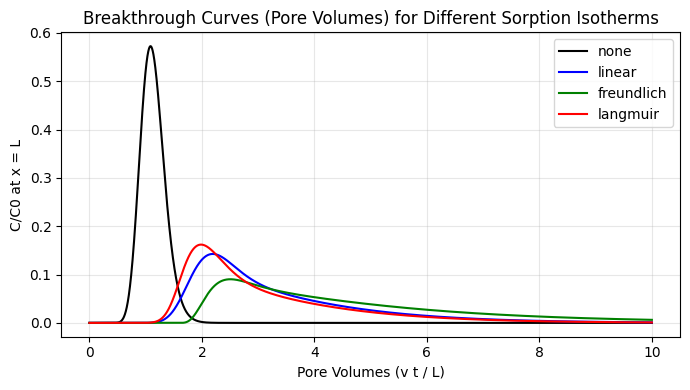

In [5]:
# Compare breakthrough curves for different sorption types
sorption_cases = ['none', 'linear', 'freundlich', 'langmuir']
colors = ['k', 'b', 'g', 'r']

plt.figure(figsize=(7, 4))
for s_case, col in zip(sorption_cases, colors):
    C = np.full_like(x, 1e-20)  # small nonzero for Freundlich stability
    Cs2 = np.zeros_like(x)  # kinetic sorbed concentration
    btc_t_case = []
    btc_c_case = []

    for n in range(nt + 1):
        t = n * dt

        if bc_type == 'flux':
            J = J0 if t <= t_p else 0.0
            C_in = 0.0
        else:
            J = 0.0
            C_in = C0 if t <= t_p else 0.0

        btc_t_case.append(t)
        btc_c_case.append(C[-1])

        if n < nt:
            C, Cs2 = step_implicit(C, dt, dx, D, v, bc_type, J, C_in,
                                  s_case, theta, rho_b, Kd, Kf, N, Cs_max, Kl,
                                  use_two_site, F_s, alpha_s, Cs2)

    btc_c_case = np.array(btc_c_case) / C0
    pv_case = (v * np.array(btc_t_case)) / L
    plt.plot(pv_case, btc_c_case, color=col, label=s_case)

plt.xlabel('Pore Volumes (v t / L)')
plt.ylabel('C/C0 at x = L')
plt.title('Breakthrough Curves (Pore Volumes) for Different Sorption Isotherms')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


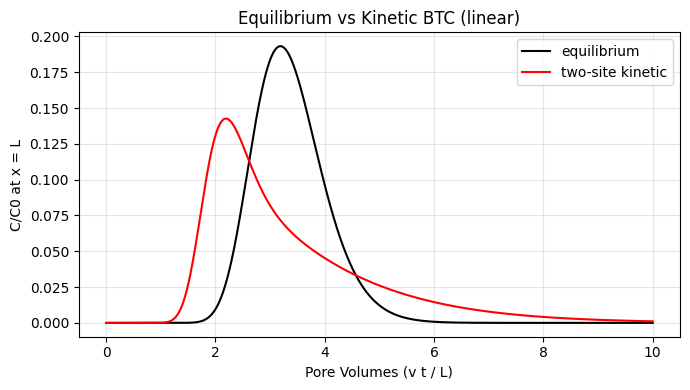

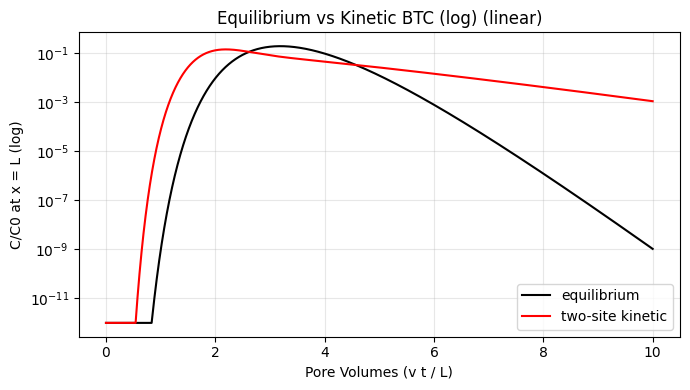

In [6]:
# Compare equilibrium vs two-site kinetic BTC (same isotherm)
def run_btc(use_two_site_flag):
    C = np.full_like(x, 1e-20)
    Cs2 = np.zeros_like(x)
    t_list = []
    c_list = []
    for n in range(nt + 1):
        t = n * dt
        if bc_type == 'flux':
            J = J0 if t <= t_p else 0.0
            C_in = 0.0
        else:
            J = 0.0
            C_in = C0 if t <= t_p else 0.0
        t_list.append(t)
        c_list.append(C[-1])
        if n < nt:
            C, Cs2 = step_implicit(C, dt, dx, D, v, bc_type, J, C_in,
                                  sorption_type, theta, rho_b, Kd, Kf, N, Cs_max, Kl,
                                  use_two_site_flag, F_s, alpha_s, Cs2)
    return np.array(t_list), np.array(c_list)

t_eq, c_eq = run_btc(False)
t_kin, c_kin = run_btc(True)

pv_eq = (v * t_eq) / L
pv_kin = (v * t_kin) / L

plt.figure(figsize=(7, 4))
c_eq_norm = c_eq / C0
c_kin_norm = c_kin / C0
plt.plot(pv_eq, c_eq_norm, label='equilibrium', color='k')
plt.plot(pv_kin, c_kin_norm, label='two-site kinetic', color='r')
plt.xlabel('Pore Volumes (v t / L)')
plt.ylabel('C/C0 at x = L')
plt.title(f'Equilibrium vs Kinetic BTC ({sorption_type})')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
c_eq_log = np.clip(c_eq_norm, 1e-12, None)
c_kin_log = np.clip(c_kin_norm, 1e-12, None)
plt.plot(pv_eq, c_eq_log, label='equilibrium', color='k')
plt.plot(pv_kin, c_kin_log, label='two-site kinetic', color='r')
plt.yscale('log')
plt.xlabel('Pore Volumes (v t / L)')
plt.ylabel('C/C0 at x = L (log)')
plt.title(f'Equilibrium vs Kinetic BTC (log) ({sorption_type})')
plt.grid(True, which='both', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


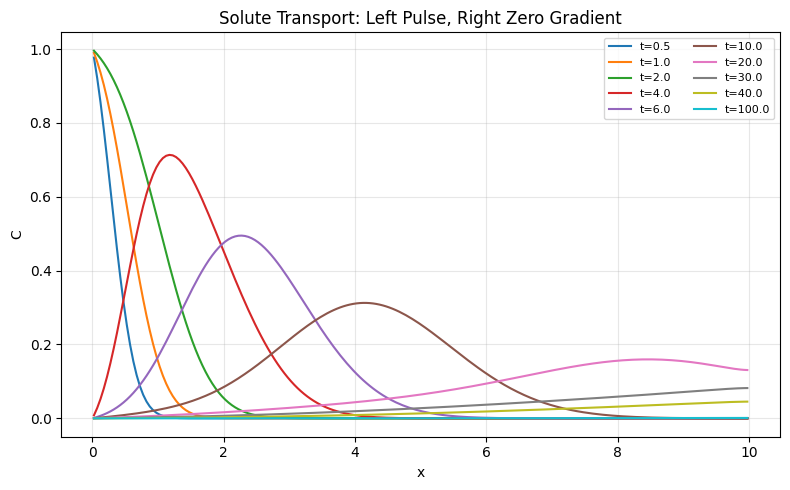

In [7]:
# Plot concentration profiles
plt.figure(figsize=(8, 5))
for t in sorted(snapshots.keys()):
    plt.plot(x, snapshots[t], label=f"t={t:.1f}")

plt.xlabel('x')
plt.ylabel('C')
plt.title('Solute Transport: Left Pulse, Right Zero Gradient')
plt.legend(ncol=2, fontsize=8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


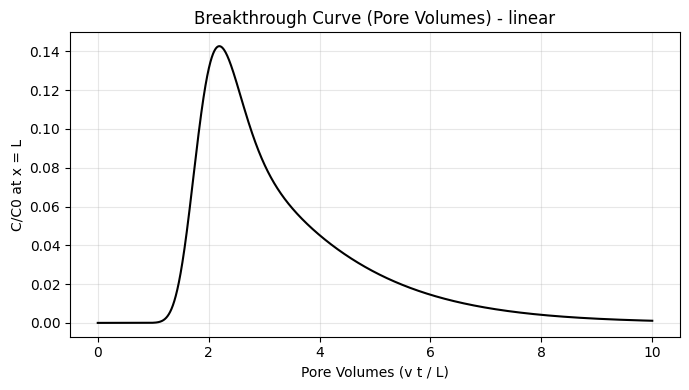

In [8]:
# Plot breakthrough curve at x = L (normalized by C0)
btc_c_norm = np.array(btc_c) / C0
pv = (v * np.array(btc_t)) / L  # pore volumes

plt.figure(figsize=(7, 4))
plt.plot(pv, btc_c_norm, color='k')
plt.xlabel('Pore Volumes (v t / L)')
plt.ylabel('C/C0 at x = L')
plt.title(f'Breakthrough Curve (Pore Volumes) - {sorption_type}')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [9]:
# Moments of the breakthrough curve using outlet mass flux (time in pore volumes)
btc_t_arr = np.array(btc_t)
btc_c_arr = np.array(btc_c)

# Pore volume time
pv_arr = (v * btc_t_arr) / L

# Outlet flux at x=L. With zero gradient, diffusive flux is zero.
F_out = v * btc_c_arr

# Zeroth absolute moment (total mass that exits, integrated over pore volumes)
M0 = np.trapezoid(F_out, pv_arr)

if M0 > 0:
    # First normalized moment (mean arrival time, in pore volumes)
    M1 = np.trapezoid(pv_arr * F_out, pv_arr)
    m1 = M1 / M0

    # Adjusted first moment (subtract pulse centroid, in pore volumes)
    # For a rectangular concentration pulse of duration t_p, the input centroid is t_p/2.
    t_p_pv = (v * t_p) / L
    m1_adj = m1 - 0.5 * t_p_pv

    # Central moments about the mean (in pore volumes)
    tau = pv_arr - m1
    mu2 = np.trapezoid((tau**2) * F_out, pv_arr) / M0
    mu3 = np.trapezoid((tau**3) * F_out, pv_arr) / M0
    mu4 = np.trapezoid((tau**4) * F_out, pv_arr) / M0

    print(f"Zeroth absolute moment (M0) = {M0:.4f}")
    print(f"First normalized moment (m1) = {m1:.4f}")
    print(f"Adjusted first moment (m1 - t_p/2) = {m1_adj:.4f}")
    print(f"Second central moment (mu2) = {mu2:.4f}")
    print(f"Third central moment (mu3) = {mu3:.4f}")
    print(f"Fourth central moment (mu4) = {mu4:.4f}")
else:
    print('Moments undefined (zero mass in BTC).')


Zeroth absolute moment (M0) = 0.2994
First normalized moment (m1) = 3.3285
Adjusted first moment (m1 - t_p/2) = 3.1785
Second central moment (mu2) = 2.3213
Third central moment (mu3) = 5.0558
Fourth central moment (mu4) = 26.9518
